Data Loading & Preprocessing

In [1]:
# load the ES_part_x files up to number 11 into df_es
import numpy as np
import pandas as pd
df_es = pd.DataFrame()

for i in range(1, 12):
    file_name = f'ES_part_{i}.csv'
    try:
        df_part = pd.read_csv(file_name)
        df_es = pd.concat([df_es, df_part], ignore_index=True)
    except FileNotFoundError:
        print(f"File {file_name} not found. Skipping.")


# set Date column to datetime
df_es['Date'] = pd.to_datetime(df_es['Date'], errors='coerce')

# set Date as index and combine date with Time column so that it is a datetime index
df_es['DateTime'] = pd.to_datetime(df_es['Date'].astype(str) + ' ' + df_es['Time'], errors='coerce')
df_es.set_index('DateTime', inplace=True)
# drop the original Date and Time columns
df_es.drop(columns=['Date', 'Time'], inplace=True)
# sort the index
df_es.sort_index(inplace=True)


# Surprise Dataframe
# Load the Surprise dataset
df_surprise = pd.read_csv('US_economic_releases_events.csv')

df_surprise.drop(columns=['S', 'Month', 'Surv(A)', 'Surv(H)', 'Surv(L)', 'Flag', 'Country/Region', 'Day', 'C', 'Category','Subcategory', 'Period', 'Actual'], inplace=True)
# Drop rows where surprise is NaN or -- (indicating no surprise)
df_surprise.dropna(subset=['Surprise'], inplace=True)
df_surprise = df_surprise[df_surprise['Surprise'] != '--']
# remove surprise values that are NaN or 0
df_surprise = df_surprise[df_surprise['Surprise'].notna() & (df_surprise['Surprise'] != 0)]
# Change surprise column to numeric, coercing errors
df_surprise['Surprise'] = pd.to_numeric(df_surprise['Surprise'], errors='coerce')

# Drop rows where Time is NaN
df_surprise.dropna(subset=['Time'], inplace=True)

# Convert Unnamed: 0 column to datetime
df_surprise['Unnamed: 0'] = pd.to_datetime(df_surprise['Unnamed: 0'], errors='coerce')
# Combine datetime column with Time column and set as index
df_surprise['DateTime'] = pd.to_datetime(df_surprise['Unnamed: 0'].astype(str) + ' ' + df_surprise['Time'], errors='coerce')
df_surprise.set_index('DateTime', inplace=True)
# Drop the original Unnamed: 0 and Time columns
df_surprise.drop(columns=['Unnamed: 0', 'Time'], inplace=True)
# Sort the index
df_surprise.sort_index(inplace=True)

# remove surprise values that are NaN or 0
df_surprise = df_surprise[df_surprise['Surprise'].notna() & (df_surprise['Surprise'] != 0)]

# Combining the 2 dataframes on the index
# outer join the two DataFrames on the index
df_combined = pd.merge(df_es, df_surprise, left_index=True, right_index=True, how='outer', suffixes=('_es', '_surprise'))

# remove all rows with NaN values in Open Close / Volume - Do not take out volume, can be 0 (not necessarily a mistake)
df_combined.dropna(subset=['Open', 'Close'], inplace=True)

# Adding a column called 'Volume_L1' which is the Volume shifted by 1 day - which is the volume of the previous minute matched up with the current minute
df_combined['Volume_L1'] = df_combined['Volume'].shift(1)

# Now we create the technical explanatory variables based on literature

def create_technical_features(df):
    """
    Creates all technical features for a dataframe containing price/volume data
    and three return columns (Return, Return_half, Return_double)
    """
    # 1. Original Features
    df_combined['Volume'] = df_combined['Volume']
    df_combined['Price'] = df_combined['Open']

    # 2. Simple Moving Averages (now includes all required windows)
    ma_windows = [5, 10, 15, 20, 50, 100, 200]  # Added missing windows for crossovers
    for window in ma_windows:
        df[f'SMA{window}'] = df['Close'].rolling(window).mean() 

    # 3. Moving Average Crossovers (now all SMAs exist)
    for window in [5, 10, 15, 20, 50, 100, 200]:
        # No more need for existence check since we created all SMAs
        df[f'SMA{window}Cross'] = (df['Close'] > df[f'SMA{window}']).astype(int) # 1 for above SMA, 0 for below

    # 4. Consecutive Price Trends
    trend_periods = [10, 15, 50]
    for period in trend_periods:
        df[f'UpDown{period}'] = np.sign(df['Close'].pct_change(period)) # 1 for up, -1 for down, NaN for no change

    # Ensure we keep the original return columns
    return_cols = ['Return', 'Return_half', 'Return_double']
    for col in return_cols:
        if col in df.columns:
            df[col] = df[col]  # Maintain existing returns

    return df

# Example usage:
# df_combined must contain: 'volume', 'close' columns plus the 3 return columns
df_combined = create_technical_features(df_combined)

import datetime
import pandas as pd
import pandas_datareader as pdr

# --- 1. Set Start and End Dates, matches up with last date of df_combined ---
start = df_combined.index.min() # Get the first date from df_combined
end = df_combined.index.max()  # Get the last date from df_combined

# print start and end
print(f"Start Date: {start}, End Date: {end}")

# --- 2. Get GDP Growth Data ---
gdp_gr = pdr.DataReader('A191RL1Q225SBEA', 'fred', start, end)

# Create gdp_gr_ml dataframe
gdp_gr_ml = gdp_gr.reset_index()
gdp_gr_ml.rename(columns={'A191RL1Q225SBEA': 'gdp_gr'}, inplace=True)
gdp_gr_ml['DateTime'] = pd.to_datetime(gdp_gr_ml['DATE']) + pd.Timedelta(hours=23, minutes=59)
gdp_gr_ml = gdp_gr_ml[['DateTime', 'gdp_gr']]

# --- 3. Get VIX Data ---
vix = pdr.DataReader('VIXCLS', 'fred', start, end)

# Create vix_ml dataframe
vix_ml = vix.reset_index()
vix_ml.rename(columns={'VIXCLS': 'VIX'}, inplace=True)
vix_ml['DateTime'] = pd.to_datetime(vix_ml['DATE']) + pd.Timedelta(hours=23, minutes=59)
vix_ml = vix_ml[['DateTime', 'VIX']]

# for both datasets set 'DateTime' as index and then drop columns
gdp_gr_ml.set_index('DateTime', inplace=True)
vix_ml.set_index('DateTime', inplace=True)
# make sure sorted on datetime
gdp_gr_ml.sort_index(inplace=True)
vix_ml.sort_index(inplace=True)

# Combine with Final Dataframe

# Merge the last known GDP growth merge on index
df_combined = pd.merge_asof(
    df_combined,
    gdp_gr_ml,
    on='DateTime',
    direction='backward'
)

# Merge the last known VIX
df_combined = pd.merge_asof(
    df_combined,
    vix_ml,
    on='DateTime',
    direction='backward'
)

# Rename the merged columns to last_gdp_gr and last_vix
df_combined = df_combined.rename(columns={
    'gdp_gr': 'last_gdp_gr',
    'VIX': 'last_vix'
})

# Set DateTime column as Index
df_combined.set_index('DateTime', inplace=True)

C:\Users\jopbr\AppData\Local\Temp\ipykernel_556\2495972309.py:29: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_surprise = pd.read_csv('US_economic_releases_events.csv')


Start Date: 1997-09-10 00:01:00, End Date: 2024-12-19 16:00:00


Creating Target column and Forward Return column for performance calculation

In [2]:
import pandas as pd
import numpy as np

# Assume 'df_combined' is your existing DataFrame with an 'Open' column
# and a DateTime index.

# --- Configuration ---
# This value represents the base holding period. If your data is in minutes,
# this would be 20 minutes.
holding_period = 20 

# Define the horizons to loop through.
horizons = ['', '_half', '_double']

# --- Main Loop to Generate All Columns ---
for h in horizons:
    # 1. Determine the calculation period and descriptive minute value
    if h == '_half':
        period = holding_period // 2
        minutes = holding_period // 2
    elif h == '_double':
        period = holding_period * 2
        minutes = holding_period * 2
    else: # h == ''
        period = holding_period
        minutes = holding_period

    # 2. Define the new, descriptive column names
    return_col_name = f'Forward Return ({minutes} min)'
    target_col_name = f'Target Signal ({minutes} min)'

    # 3. Calculate the base forward return for the current horizon
    # This calculates the return based on the 'Open' price, just like the original
    # script did. It then shifts the future value back to the current row.
    base_return = df_combined['Close'].pct_change(periods=period).shift(-period)

    # 4. Create the Forward Return column
    # This is the actual future return, used for performance calculation.
    df_combined[return_col_name] = base_return
    
    # 5. Create the categorical "Target Signal" column
    # This is the target variable (y) the model will learn to predict.
    # 0 = Hold, 1 = Buy (positive future return), 2 = Sell (negative future return)
    cond_buy = df_combined[return_col_name] > 0
    cond_sell = df_combined[return_col_name] < 0

    df_combined[target_col_name] = 0  # Default to Hold
    df_combined.loc[cond_buy, target_col_name] = 1
    df_combined.loc[cond_sell, target_col_name] = 2

Create feature column for each Ticker

In [3]:
import pandas as pd
import numpy as np

# This script assumes 'df_combined' is an existing DataFrame with a DateTimeIndex
# and columns 'Ticker' and 'Surprise'.

# --- 1. Filter for Event Rows Only ---
# First, create a smaller dataframe that only contains rows where a surprise occurred.
# This makes the pivot operation much more efficient.
print("Step 1: Filtering for rows with surprise events...")
surprise_events_only = df_combined[df_combined['Surprise'].notna()].copy()
print(f"Found {len(surprise_events_only)} rows with surprise events to pivot.")


# --- 2. Pivot the Filtered Data ---
# Now, we pivot this smaller dataframe.
# - The index of the new dataframe will be the original DateTimeIndex.
# - New columns will be created from the unique values in the 'Ticker' column.
# - The values for these new columns will be taken from the 'Surprise' column.
# - `fill_value=0` is critical: it ensures that for any given event row, all ticker
#   columns that were NOT part of that event are filled with 0.
print("\nStep 2: Pivoting the data...")
event_df = surprise_events_only.pivot_table(
    index=surprise_events_only.index,
    columns='Ticker',
    values='Surprise',
    fill_value=0
)

# Optional: Add a suffix to the new column names for clarity
event_df = event_df.add_suffix('_Surprise')
print("Pivoting complete.")


# --- 3. Verify the Result ---
print("\n--- Event DataFrame Sample ---")
print(event_df.head())

print(f"\nShape of the new event DataFrame: {event_df.shape}")
print(f"Number of rows matches the number of events, and number of columns matches unique tickers.")

# The `event_df` is now ready. It only contains rows from event times,
# and each ticker has its own column filled with either the surprise value or 0.


Step 1: Filtering for rows with surprise events...
Found 23303 rows with surprise events to pivot.

Step 2: Pivoting the data...
Pivoting complete.

--- Event DataFrame Sample ---
Ticker               ACNFCOMF Index_Surprise  ADP CHNG Index_Surprise  \
DateTime                                                                
1997-12-23 07:30:00                      0.0                      0.0   
1998-03-26 07:30:00                      0.0                      0.0   
1998-04-30 07:30:00                      0.0                      0.0   
1998-06-01 09:00:00                      0.0                      0.0   
1998-06-02 09:00:00                      0.0                      0.0   

Ticker               AHE MOM% Index_Surprise  AHE YOY% Index_Surprise  \
DateTime                                                                
1997-12-23 07:30:00                      0.0                      0.0   
1998-03-26 07:30:00                      0.0                      0.0   
1998-04-30 07:30

In [4]:
# Step 2: Selecting feature and target columns from df_combined
# all columns with 'SMA' at start or 'UpDown' and 'Last_GDP_GR' and 'Last_VIX' at the end and
feature_columns = [col for col in df_combined.columns if col.startswith('SMA') or col.startswith('UpDown') or col in ['last_gdp_gr', 'last_vix']]
columns_to_join = feature_columns

# also include the 'R' and 'Volume_L1' and 'Surprise' columns
columns_to_join += ['R', 'Volume_L1', 'Surprise', 'Std Dev']

# also include the return columns
list = [
    'Forward Return (20 min)',
    'Target Signal (20 min)',
    'Forward Return (10 min)',
    'Target Signal (10 min)',
    'Forward Return (40 min)',
    'Target Signal (40 min)'
]

columns_to_join += list

features_and_target_from_combined = df_combined[columns_to_join]

ml_df = event_df.join(features_and_target_from_combined, how='inner')

# Clean up any potential NaNs that might arise from the join, just in case.
ml_df.fillna(0, inplace=True)

print("Join complete.")


# --- 4. Verify the Final DataFrame ---
print("\n--- Final ML-Ready DataFrame ---")
print(ml_df.head())

print(f"\nShape of the final DataFrame: {ml_df.shape}")
print(f"The number of rows ({ml_df.shape[0]}) should match the number of surprise events.")
print("\nFinal columns available for the model:")
print(ml_df.columns.tolist())

# The `ml_df` DataFrame is now complete and ready to be split into X (all columns except Target)
# and y (the Target column) to be fed into your XGBoost model.

Join complete.

--- Final ML-Ready DataFrame ---
                     ACNFCOMF Index_Surprise  ADP CHNG Index_Surprise  \
DateTime                                                                
1997-12-23 07:30:00                      0.0                      0.0   
1998-03-26 07:30:00                      0.0                      0.0   
1998-04-30 07:30:00                      0.0                      0.0   
1998-06-01 09:00:00                      0.0                      0.0   
1998-06-02 09:00:00                      0.0                      0.0   

                     AHE MOM% Index_Surprise  AHE YOY% Index_Surprise  \
DateTime                                                                
1997-12-23 07:30:00                      0.0                      0.0   
1998-03-26 07:30:00                      0.0                      0.0   
1998-04-30 07:30:00                      0.0                      0.0   
1998-06-01 09:00:00                      0.0                      0.0   
1

In [5]:
# rename ml_df to df_ml
df_ml = ml_df

# adjust df_ml so that index, DateTime, become a single column
df_ml.reset_index(inplace=True)

df_ml

,DateTime,ACNFCOMF Index_Surprise,ADP CHNG Index_Surprise,AHE MOM% Index_Surprise,AHE YOY% Index_Surprise,AMSPPACE Index_Surprise,AWH TOTL Index_Surprise,CFNAI Index_Surprise,CGNOXAI% Index_Surprise,CGSHXAI% Index_Surprise,...,R,Volume_L1,Surprise,Std Dev,Forward Return (20 min),Target Signal (20 min),Forward Return (10 min),Target Signal (10 min),Forward Return (40 min),Target Signal (40 min)
0,1997-12-23 07:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,96.296300,0.0,-2.98,0.07,0.000000,0,0.000261,1,-0.000261,2
1,1998-03-26 07:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,96.296300,0.0,-2.52,0.08,-0.000457,2,0.001571,1,-0.000229,2
2,1998-04-30 07:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,96.296300,0.0,2.22,0.36,0.012548,1,0.009807,1,0.013235,1
3,1998-06-01 09:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,94.814800,0.0,-1.88,0.77,0.003439,1,0.003206,1,0.003206,1
4,1998-06-02 09:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,88.148100,0.0,3.69,13.02,0.000454,1,0.000454,1,-0.001594,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23298,2024-12-18 07:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,61.185200,131.0,3.38,22.21,-0.001505,2,-0.000325,2,-0.002970,2
23299,2024-12-18 07:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,31.851900,131.0,2.87,1.78,-0.001668,2,-0.000488,2,-0.003010,2
23300,2024-12-18 07:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,71.111100,131.0,-3.84,6.22,-0.001546,2,-0.000529,2,-0.002847,2
23301,2024-12-18 13:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.222220,1239.0,2.03,0.12,-0.008963,2,-0.006478,2,-0.010023,2


XGBoost model - USA - Excluding Transaction costs

Feature Columns: ['ACNFCOMF Index_Surprise', 'ADP CHNG Index_Surprise', 'AHE MOM% Index_Surprise', 'AHE YOY% Index_Surprise', 'AMSPPACE Index_Surprise', 'AWH TOTL Index_Surprise', 'CFNAI Index_Surprise', 'CGNOXAI% Index_Surprise', 'CGSHXAI% Index_Surprise', 'CHPMINDX Index_Surprise', 'CICRTOT Index_Surprise', 'CNSTTMOM Index_Surprise', 'COMFCOMF Index_Surprise', 'CONCCONF Index_Surprise', 'CONSCURR Index_Surprise', 'CONSEXP Index_Surprise', 'CONSP5MD Index_Surprise', 'CONSPXMD Index_Surprise', 'CONSSENT Index_Surprise', 'COSTNFR% Index_Surprise', 'CPI CHNG Index_Surprise', 'CPI XYOY Index_Surprise', 'CPI YOY Index_Surprise', 'CPTICHNG Index_Surprise', 'CPUPAXFE Index_Surprise', 'CPUPXCHG Index_Surprise', 'CPURNSA Index_Surprise', 'DFEDGBA Index_Surprise', 'DGNOCHNG Index_Surprise', 'DGNOXTCH Index_Surprise', 'DOTDLTMD Index_Surprise', 'DOTDY0MD Index_Surprise', 'DOTDY1MD Index_Surprise', 'DOTDY2MD Index_Surprise', 'DSERGBCC Index_Surprise', 'ECI SA% Index_Surprise', 'ECONUSIB Index_Sur

C:\Users\jopbr\AppData\Local\Temp\ipykernel_556\3461239018.py:183: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  val_returns = val_trade_df.groupby('DateTime').apply(
C:\Users\jopbr\AppData\Local\Temp\ipykernel_556\3461239018.py:183: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  val_returns = val_trade_df.groupby('DateTime').apply(
C:\Users\jopbr\AppData\Local\Temp\ipykernel_556\3461239018.py:183: Deprecati

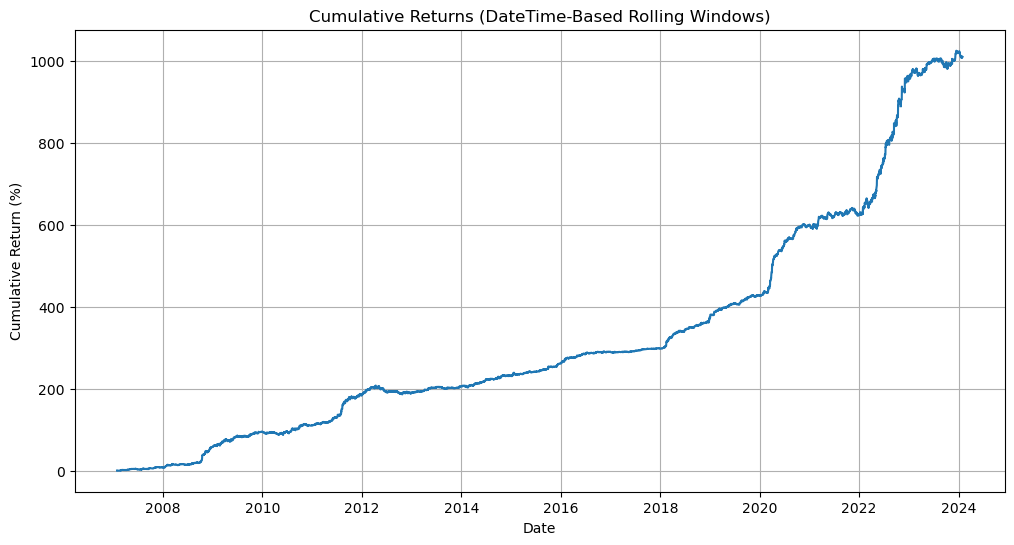

Final Cumulative Compounded Return: 1008.73%

Overall Test Accuracy : 52.09%
Overall Precision     : 36.80%
Overall Recall        : 36.24%
Overall F1 Score      : 35.63%
Overall ROC AUC       : 57.88%

Average Fold Test Return : 0.03451%

Standard Deviation of All Test Returns (Aggregated Daily): 0.25341%

Minimum Return (Aggregated Daily): -0.76154%

Optimal Horizon Counts:
(40 min)    9
(20 min)    5
(10 min)    3
Name: count, dtype: int64

Test Set Position Counts:
Neutral (0): 50
Long (1): 9608
Short (2): 7758


In [6]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
os.environ['PYTHONHASHSEED'] = '0'

import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score
)
import numpy as np
import pandas as pd
import random

# transaction costs
transaction_cost = 0.000000
# feature_cols = all columns except 'DateTime' and the last 6 columns and also print out feature_cols and number of features
feature_cols = df_ml.columns[:-6].tolist()
feature_cols.remove('DateTime')
print("Feature Columns:", feature_cols)
print("Number of Features:", len(feature_cols))


# --- Configuration ---
total_cost = 2 * transaction_cost
horizons = [' (20 min)', ' (10 min)', ' (40 min)']

# --- Data Prep ---
df_ml = df_ml.dropna(subset=['Surprise']).sort_values('DateTime')
min_date = df_ml['DateTime'].min()
max_date = df_ml['DateTime'].max()

# --- Calculate Initial 30% Training Period ---
total_duration = max_date - min_date
initial_train_duration = total_duration * 0.3
train_end_date = min_date + initial_train_duration

# --- Tracking containers ---
results = []
all_test_returns = []
all_dates = []
all_test_preds = []
all_test_truths = []
all_test_probas = []
fold_mean_returns = []
best_horizons_list = []

def calculate_grouped_returns(df_group, horizon, stop_loss=None):
    """Calculate returns with position sizing and stop loss"""
    active_trades = df_group[df_group['pred'] != 0]
    if active_trades.empty:
        return 0.0

    longs = active_trades[active_trades['pred'] == 1]
    shorts = active_trades[active_trades['pred'] == 2]

    total_confidence = longs['proba'].sum() + shorts['proba'].sum()
    if total_confidence == 0:
        return 0.0

    num_trades = len(longs) + len(shorts)
    total_costs = total_cost * num_trades

    long_returns = 0.0
    short_returns = 0.0

    # Process longs
    if not longs.empty:
        long_weights = longs['proba'] / total_confidence
        for idx, row in longs.iterrows():
            raw_return = row[f'Forward Return{horizon}']
            capped_raw = max(stop_loss, raw_return) if stop_loss is not None else raw_return
            long_returns += capped_raw * long_weights.loc[idx]

    # Process shorts
    if not shorts.empty:
        short_weights = shorts['proba'] / total_confidence
        for idx, row in shorts.iterrows():
            raw_return = -row[f'Forward Return{horizon}']
            capped_raw = max(stop_loss, raw_return) if stop_loss is not None else raw_return
            short_returns += capped_raw * short_weights.loc[idx]

    net_return = (long_returns + short_returns) - total_costs
    return net_return

# --- Main Loop ---
while True:
    val_start_date = train_end_date + pd.DateOffset(days=1)
    val_end_date = val_start_date + pd.DateOffset(years=1)
    test_start_date = val_end_date + pd.DateOffset(days=1)
    test_end_date = test_start_date + pd.DateOffset(years=1)

    if val_end_date > max_date or test_end_date > max_date:
        break

    train_mask = df_ml['DateTime'] <= train_end_date
    val_mask = (df_ml['DateTime'] >= val_start_date) & (df_ml['DateTime'] <= val_end_date)
    test_mask = (df_ml['DateTime'] >= test_start_date) & (df_ml['DateTime'] <= test_end_date)

    train_data = df_ml[train_mask]
    val_data = df_ml[val_mask]
    test_data = df_ml[test_mask]

    if val_data.empty or test_data.empty:
        print(f"Skipping period {val_start_date.date()} to {test_end_date.date()} (no data)")
        train_end_date += pd.DateOffset(years=1)
        continue

    # --- Horizon Optimization ---
    best_horizon, best_model, best_stop_loss = None, None, None
    best_val_return = -np.inf

    for horizon in horizons:
        # Feature scaling
        scaler = StandardScaler()
        X_train = scaler.fit_transform(train_data[feature_cols])
        X_val = scaler.transform(val_data[feature_cols])
        y_train = train_data[f'Target Signal{horizon}']
        y_val = val_data[f'Target Signal{horizon}']

        # Train model
        model = xgb.XGBClassifier(
            num_class=3,
            n_estimators=60,
            max_depth=7,
            random_state=42,
            seed=42
        )
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

        # Calculate training stop loss
        train_preds = model.predict(X_train)
        train_trade_df = pd.DataFrame({
            'DateTime': train_data['DateTime'],
            'pred': train_preds,
            'proba': [p[pred] for pred, p in zip(train_preds, model.predict_proba(X_train))],
            f'Forward Return{horizon}': train_data[f'Forward Return{horizon}']
        })

        individual_train_returns = []
        for _, row in train_trade_df.iterrows():
            if row['pred'] == 1:
                raw = row[f'Forward Return{horizon}']
            elif row['pred'] == 2:
                raw = -row[f'Forward Return{horizon}']
            else:
                continue
            individual_train_returns.append(raw)

        stop_loss_train = np.percentile(individual_train_returns, 5) if individual_train_returns else None

        # Calculate validation stop loss (for test set)
        val_preds = model.predict(X_val)
        val_probas = model.predict_proba(X_val)
        val_trade_df = pd.DataFrame({
            'DateTime': val_data['DateTime'],
            'pred': val_preds,
            'proba': [p[pred] for pred, p in zip(val_preds, val_probas)],
            f'Forward Return{horizon}': val_data[f'Forward Return{horizon}']
        })

        individual_val_returns = []
        for _, row in val_trade_df.iterrows():
            if row['pred'] == 1:
                raw = row[f'Forward Return{horizon}']
            elif row['pred'] == 2:
                raw = -row[f'Forward Return{horizon}']
            else:
                continue
            individual_val_returns.append(raw)

        stop_loss_val = np.percentile(individual_val_returns, 5) if individual_val_returns else None

        # Validate using TRAINING stop loss
        val_returns = val_trade_df.groupby('DateTime').apply(
            lambda x: calculate_grouped_returns(x, horizon, stop_loss_train)
        ).values

        total_val_return = (1 + val_returns).prod() - 1

        if total_val_return > best_val_return:
            best_val_return = total_val_return
            best_horizon = horizon
            best_model = model
            best_stop_loss = stop_loss_val  # Save validation stop loss for test

    # --- Test Best Model ---
    if best_model and best_stop_loss is not None:
        X_test = scaler.transform(test_data[feature_cols])
        test_preds = best_model.predict(X_test)
        test_probas = best_model.predict_proba(X_test)
        y_test = test_data[f'Target Signal{best_horizon}'].values

        test_trade_df = pd.DataFrame({
            'DateTime': test_data['DateTime'],
            'pred': test_preds,
            'proba': [p[pred] for pred, p in zip(test_preds, test_probas)],
            f'Forward Return{best_horizon}': test_data[f'Forward Return{best_horizon}']
        })

        grouped_returns = test_trade_df.groupby('DateTime').apply(
            lambda x: calculate_grouped_returns(x, best_horizon, best_stop_loss)
        ).values

        all_test_returns.extend(grouped_returns)
        all_dates.extend(test_trade_df['DateTime'].unique().tolist())
        all_test_preds.extend(test_preds)
        all_test_truths.extend(y_test)
        all_test_probas.append(test_probas)
        fold_mean_returns.append(np.mean(grouped_returns))
        best_horizons_list.append(best_horizon or 'standard')

    train_end_date += pd.DateOffset(years=1)

# --- Results ---
if all_test_returns:
    cumulative_returns = (1 + np.array(all_test_returns)).cumprod() - 1
    std_dev_individual = np.std(all_test_returns) * 100
    min_return = np.nanmin(all_test_returns) * 100 if all_test_returns else 0.0

    plt.figure(figsize=(12, 6))
    plt.plot(all_dates, cumulative_returns * 100)
    plt.title('Cumulative Returns (DateTime-Based Rolling Windows)')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return (%)')
    plt.grid(True)
    plt.show()

    print(f"Final Cumulative Compounded Return: {cumulative_returns[-1]*100:.2f}%")
    print(f"\nOverall Test Accuracy : {accuracy_score(all_test_truths, all_test_preds)*100:.2f}%")
    print(f"Overall Precision     : {precision_score(all_test_truths, all_test_preds, average='macro', zero_division=0)*100:.2f}%")
    print(f"Overall Recall        : {recall_score(all_test_truths, all_test_preds, average='macro', zero_division=0)*100:.2f}%")
    print(f"Overall F1 Score      : {f1_score(all_test_truths, all_test_preds, average='macro', zero_division=0)*100:.2f}%")
    print(f"Overall ROC AUC       : {roc_auc_score(all_test_truths, np.vstack(all_test_probas), multi_class='ovo', average='macro')*100:.2f}%")
    print(f"\nAverage Fold Test Return : {np.mean(fold_mean_returns)*100:.5f}%")
    print(f"\nStandard Deviation of All Test Returns (Aggregated Daily): {std_dev_individual:.5f}%")
    print(f"\nMinimum Return (Aggregated Daily): {min_return:.5f}%")
    print("\nOptimal Horizon Counts:")
    print(pd.Series(best_horizons_list).value_counts())
    print("\nTest Set Position Counts:")
    counts = pd.Series(all_test_preds).value_counts().sort_index()
    print(f"Neutral (0): {counts.get(0, 0)}")
    print(f"Long (1): {counts.get(1, 0)}")
    print(f"Short (2): {counts.get(2, 0)}")

else:
    print("No valid test periods found")

In [7]:
# XGB confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

# Add this after your existing print statements
print("\nConfusion Matrix:")
cm = confusion_matrix(all_test_truths, all_test_preds)
cm_df = pd.DataFrame(cm,
                    index=['Actual Neutral (0)', 'Actual Long (1)', 'Actual Short (2)'],
                    columns=['Pred Neutral (0)', 'Pred Long (1)', 'Pred Short (2)'])
print(cm_df)

print("\nClassification Report:")
print(classification_report(all_test_truths, all_test_preds,
                           target_names=['Neutral (0)', 'Long (1)', 'Short (2)']))


Confusion Matrix:
                    Pred Neutral (0)  Pred Long (1)  Pred Short (2)
Actual Neutral (0)                 3            364             315
Actual Long (1)                   17           5035            3409
Actual Short (2)                  30           4209            4034

Classification Report:
              precision    recall  f1-score   support

 Neutral (0)       0.06      0.00      0.01       682
    Long (1)       0.52      0.60      0.56      8461
   Short (2)       0.52      0.49      0.50      8273

    accuracy                           0.52     17416
   macro avg       0.37      0.36      0.36     17416
weighted avg       0.50      0.52      0.51     17416



Random Forest USA - Excluding Transaction Cost

Feature Columns: ['ACNFCOMF Index_Surprise', 'ADP CHNG Index_Surprise', 'AHE MOM% Index_Surprise', 'AHE YOY% Index_Surprise', 'AMSPPACE Index_Surprise', 'AWH TOTL Index_Surprise', 'CFNAI Index_Surprise', 'CGNOXAI% Index_Surprise', 'CGSHXAI% Index_Surprise', 'CHPMINDX Index_Surprise', 'CICRTOT Index_Surprise', 'CNSTTMOM Index_Surprise', 'COMFCOMF Index_Surprise', 'CONCCONF Index_Surprise', 'CONSCURR Index_Surprise', 'CONSEXP Index_Surprise', 'CONSP5MD Index_Surprise', 'CONSPXMD Index_Surprise', 'CONSSENT Index_Surprise', 'COSTNFR% Index_Surprise', 'CPI CHNG Index_Surprise', 'CPI XYOY Index_Surprise', 'CPI YOY Index_Surprise', 'CPTICHNG Index_Surprise', 'CPUPAXFE Index_Surprise', 'CPUPXCHG Index_Surprise', 'CPURNSA Index_Surprise', 'DFEDGBA Index_Surprise', 'DGNOCHNG Index_Surprise', 'DGNOXTCH Index_Surprise', 'DOTDLTMD Index_Surprise', 'DOTDY0MD Index_Surprise', 'DOTDY1MD Index_Surprise', 'DOTDY2MD Index_Surprise', 'DSERGBCC Index_Surprise', 'ECI SA% Index_Surprise', 'ECONUSIB Index_Sur

C:\Users\jopbr\AppData\Local\Temp\ipykernel_556\1890306692.py:176: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  val_returns = val_trade_df.groupby('DateTime').apply(
C:\Users\jopbr\AppData\Local\Temp\ipykernel_556\1890306692.py:176: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  val_returns = val_trade_df.groupby('DateTime').apply(
C:\Users\jopbr\AppData\Local\Temp\ipykernel_556\1890306692.py:176: Deprecati

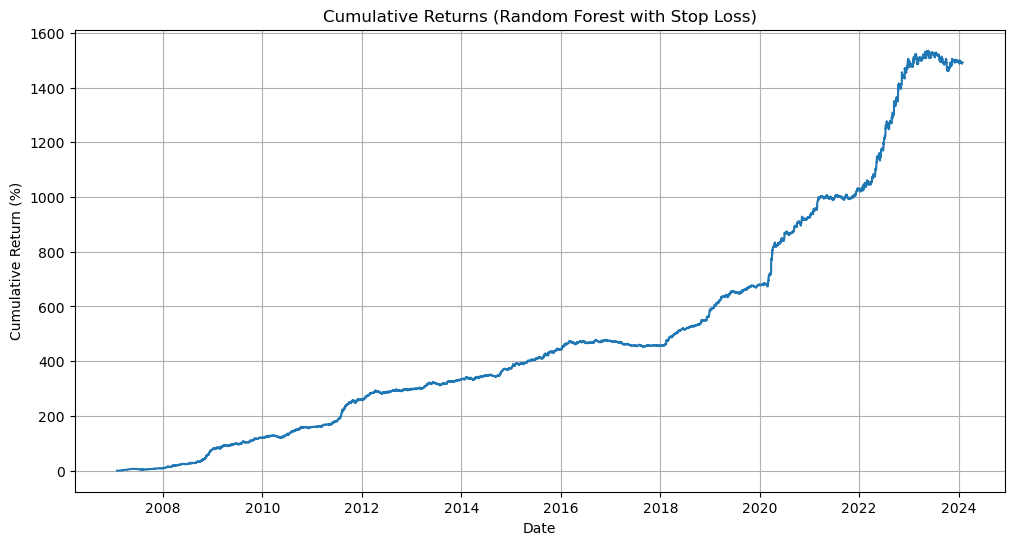

Final Cumulative Compounded Return: 1491.50%

Overall Test Accuracy : 52.64%
Overall Precision     : 35.07%
Overall Recall        : 36.19%
Overall F1 Score      : 35.62%
Overall ROC AUC       : 56.23%

Average Fold Test Return : 0.03947%

Standard Deviation of All Test Returns (Aggregated Daily): 0.27455%

Minimum Return (Aggregated Daily): -0.88309%

Optimal Horizon Counts:
(40 min)    17
Name: count, dtype: int64

Test Set Position Counts:
Neutral (0): 4
Long (1): 9025
Short (2): 8387


In [9]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
os.environ['PYTHONHASHSEED'] = '0'

from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score
)
import numpy as np
import pandas as pd
import random

# feature_cols = all columns except 'DateTime' and the last 6 columns and also print out feature_cols and number of features
feature_cols = df_ml.columns[:-6].tolist()
feature_cols.remove('DateTime')
print("Feature Columns:", feature_cols)
print("Number of Features:", len(feature_cols))


# --- Configuration ---
horizons = [' (20 min)', ' (10 min)', ' (40 min)']

# --- Data Prep ---
df_ml = df_ml.dropna(subset=['Surprise']).sort_values('DateTime')
min_date = df_ml['DateTime'].min()
max_date = df_ml['DateTime'].max()

# --- Calculate Initial 30% Training Period ---
total_duration = max_date - min_date
initial_train_duration = total_duration * 0.3
train_end_date = min_date + initial_train_duration

# --- Tracking containers ---
results = []
all_test_returns = []
all_dates = []
all_test_preds = []
all_test_truths = []
all_test_probas = []
fold_mean_returns = []
best_horizons_list = []

def calculate_grouped_returns(df_group, horizon, stop_loss=None):
    """Calculate returns with position sizing and stop loss"""
    active_trades = df_group[df_group['pred'] != 0]
    if active_trades.empty:
        return 0.0

    # Create copies with reset index
    longs = active_trades[active_trades['pred'] == 1].copy().reset_index(drop=True)
    shorts = active_trades[active_trades['pred'] == 2].copy().reset_index(drop=True)

    total_confidence = longs['proba'].sum() + shorts['proba'].sum()
    if total_confidence == 0:
        return 0.0

    num_trades = len(longs) + len(shorts)

    long_returns = 0.0
    short_returns = 0.0

    # Process longs with reset index
    if not longs.empty:
        long_weights = longs['proba'] / total_confidence
        for idx in longs.index:
            raw_return = longs.loc[idx, f'Forward Return{horizon}']
            capped_raw = max(stop_loss, raw_return) if stop_loss is not None else raw_return
            long_returns += capped_raw * long_weights.loc[idx]

    # Process shorts with reset index
    if not shorts.empty:
        short_weights = shorts['proba'] / total_confidence
        for idx in shorts.index:
            raw_return = -shorts.loc[idx, f'Forward Return{horizon}']
            capped_raw = max(stop_loss, raw_return) if stop_loss is not None else raw_return
            short_returns += capped_raw * short_weights.loc[idx]

    net_return = (long_returns + short_returns)
    return net_return

# --- Main Loop ---
while True:
    val_start_date = train_end_date + pd.DateOffset(days=1)
    val_end_date = val_start_date + pd.DateOffset(years=1)
    test_start_date = val_end_date + pd.DateOffset(days=1)
    test_end_date = test_start_date + pd.DateOffset(years=1)

    if val_end_date > max_date or test_end_date > max_date:
        break

    train_mask = df_ml['DateTime'] <= train_end_date
    val_mask = (df_ml['DateTime'] >= val_start_date) & (df_ml['DateTime'] <= val_end_date)
    test_mask = (df_ml['DateTime'] >= test_start_date) & (df_ml['DateTime'] <= test_end_date)

    train_data = df_ml[train_mask]
    val_data = df_ml[val_mask]
    test_data = df_ml[test_mask]

    if val_data.empty or test_data.empty:
        print(f"Skipping period {val_start_date.date()} to {test_end_date.date()} (no data)")
        train_end_date += pd.DateOffset(years=1)
        continue

    # --- Horizon Optimization ---
    best_horizon, best_model, best_stop_loss = None, None, None
    best_val_return = -np.inf

    for horizon in horizons:
        # Feature scaling
        scaler = StandardScaler()
        X_train = scaler.fit_transform(train_data[feature_cols])
        X_val = scaler.transform(val_data[feature_cols])
        y_train = train_data[f'Target Signal{horizon}']
        y_val = val_data[f'Target Signal{horizon}']

        # Train model
        model = RandomForestClassifier(
            n_estimators=100,
            criterion='gini',
            min_samples_leaf=4,
            random_state=42
        )
        model.fit(X_train, y_train)

        # Get class probabilities
        train_preds = model.predict(X_train)
        train_probas = model.predict_proba(X_train)
        class_map = {cls: idx for idx, cls in enumerate(model.classes_)}

        # Training stop loss calculation
        train_trade_df = pd.DataFrame({
            'DateTime': train_data['DateTime'],
            'pred': train_preds,
            'proba': [proba[class_map[pred]] for pred, proba in zip(train_preds, train_probas)],
            f'Forward Return{horizon}': train_data[f'Forward Return{horizon}']
        })

        train_raw_returns = []
        for _, row in train_trade_df.iterrows():
            if row['pred'] == 1:
                train_raw_returns.append(row[f'Forward Return{horizon}'])
            elif row['pred'] == 2:
                train_raw_returns.append(-row[f'Forward Return{horizon}'])
        stop_loss_train = np.percentile(train_raw_returns, 5) if train_raw_returns else None

        # Validation predictions
        val_preds = model.predict(X_val)
        val_probas = model.predict_proba(X_val)
        val_trade_df = pd.DataFrame({
            'DateTime': val_data['DateTime'],
            'pred': val_preds,
            'proba': [proba[class_map[pred]] for pred, proba in zip(val_preds, val_probas)],
            f'Forward Return{horizon}': val_data[f'Forward Return{horizon}']
        })

        # Validation stop loss calculation (for test set)
        val_raw_returns = []
        for _, row in val_trade_df.iterrows():
            if row['pred'] == 1:
                val_raw_returns.append(row[f'Forward Return{horizon}'])
            elif row['pred'] == 2:
                val_raw_returns.append(-row[f'Forward Return{horizon}'])
        stop_loss_val = np.percentile(val_raw_returns, 5) if val_raw_returns else None

        # Validate using training stop loss
        val_returns = val_trade_df.groupby('DateTime').apply(
            lambda x: calculate_grouped_returns(x, horizon, stop_loss_train)
        ).values

        total_val_return = (1 + val_returns).prod() - 1

        if total_val_return > best_val_return:
            best_val_return = total_val_return
            best_horizon = horizon
            best_model = model
            best_stop_loss = stop_loss_val

    # --- Test Best Model ---
    if best_model and best_stop_loss is not None:
        X_test = scaler.transform(test_data[feature_cols])
        test_preds = best_model.predict(X_test)
        test_probas = best_model.predict_proba(X_test)
        y_test = test_data[f'Target Signal{best_horizon}'].values

        class_map = {cls: idx for idx, cls in enumerate(best_model.classes_)}
        test_trade_df = pd.DataFrame({
            'DateTime': test_data['DateTime'],
            'pred': test_preds,
            'proba': [proba[class_map[pred]] for pred, proba in zip(test_preds, test_probas)],
            f'Forward Return{best_horizon}': test_data[f'Forward Return{best_horizon}']
        })

        grouped_returns = test_trade_df.groupby('DateTime').apply(
            lambda x: calculate_grouped_returns(x, best_horizon, best_stop_loss)
        ).values

        all_test_returns.extend(grouped_returns)
        all_dates.extend(test_trade_df['DateTime'].unique().tolist())
        all_test_preds.extend(test_preds)
        all_test_truths.extend(y_test)
        all_test_probas.append(test_probas)
        fold_mean_returns.append(np.mean(grouped_returns))
        best_horizons_list.append(best_horizon or 'standard')

    train_end_date += pd.DateOffset(years=1)

# --- Results ---
if all_test_returns:
    cumulative_returns = (1 + np.array(all_test_returns)).cumprod() - 1
    std_dev_individual = np.std(all_test_returns) * 100
    min_return = np.nanmin(all_test_returns) * 100 if all_test_returns else 0.0

    plt.figure(figsize=(12, 6))
    plt.plot(all_dates, cumulative_returns * 100)
    plt.title('Cumulative Returns (Random Forest with Stop Loss)')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return (%)')
    plt.grid(True)
    plt.show()

    print(f"Final Cumulative Compounded Return: {cumulative_returns[-1]*100:.2f}%")
    print(f"\nOverall Test Accuracy : {accuracy_score(all_test_truths, all_test_preds)*100:.2f}%")
    print(f"Overall Precision     : {precision_score(all_test_truths, all_test_preds, average='macro', zero_division=0)*100:.2f}%")
    print(f"Overall Recall        : {recall_score(all_test_truths, all_test_preds, average='macro', zero_division=0)*100:.2f}%")
    print(f"Overall F1 Score      : {f1_score(all_test_truths, all_test_preds, average='macro', zero_division=0)*100:.2f}%")
    print(f"Overall ROC AUC       : {roc_auc_score(all_test_truths, np.vstack(all_test_probas), multi_class='ovo', average='macro')*100:.2f}%")
    print(f"\nAverage Fold Test Return : {np.mean(fold_mean_returns)*100:.5f}%")
    print(f"\nStandard Deviation of All Test Returns (Aggregated Daily): {std_dev_individual:.5f}%")
    print(f"\nMinimum Return (Aggregated Daily): {min_return:.5f}%")
    print("\nOptimal Horizon Counts:")
    print(pd.Series(best_horizons_list).value_counts())
    print("\nTest Set Position Counts:")
    counts = pd.Series(all_test_preds).value_counts().sort_index()
    print(f"Neutral (0): {counts.get(0, 0)}")
    print(f"Long (1): {counts.get(1, 0)}")
    print(f"Short (2): {counts.get(2, 0)}")

else:
    print("No valid test periods found")

In [10]:
# LR confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

# Add this after your existing print statements
print("\nConfusion Matrix:")
cm = confusion_matrix(all_test_truths, all_test_preds)
cm_df = pd.DataFrame(cm,
                    index=['Actual Neutral (0)', 'Actual Long (1)', 'Actual Short (2)'],
                    columns=['Pred Neutral (0)', 'Pred Long (1)', 'Pred Short (2)'])
print(cm_df)

print("\nClassification Report:")
print(classification_report(all_test_truths, all_test_preds,
                           target_names=['Neutral (0)', 'Long (1)', 'Short (2)']))


Confusion Matrix:
                    Pred Neutral (0)  Pred Long (1)  Pred Short (2)
Actual Neutral (0)                 0            264             279
Actual Long (1)                    2           4846            3787
Actual Short (2)                   2           3915            4321

Classification Report:
              precision    recall  f1-score   support

 Neutral (0)       0.00      0.00      0.00       543
    Long (1)       0.54      0.56      0.55      8635
   Short (2)       0.52      0.52      0.52      8238

    accuracy                           0.53     17416
   macro avg       0.35      0.36      0.36     17416
weighted avg       0.51      0.53      0.52     17416



Logistic Regression USA - Transaction Cost

Feature Columns: ['ACNFCOMF Index_Surprise', 'ADP CHNG Index_Surprise', 'AHE MOM% Index_Surprise', 'AHE YOY% Index_Surprise', 'AMSPPACE Index_Surprise', 'AWH TOTL Index_Surprise', 'CFNAI Index_Surprise', 'CGNOXAI% Index_Surprise', 'CGSHXAI% Index_Surprise', 'CHPMINDX Index_Surprise', 'CICRTOT Index_Surprise', 'CNSTTMOM Index_Surprise', 'COMFCOMF Index_Surprise', 'CONCCONF Index_Surprise', 'CONSCURR Index_Surprise', 'CONSEXP Index_Surprise', 'CONSP5MD Index_Surprise', 'CONSPXMD Index_Surprise', 'CONSSENT Index_Surprise', 'COSTNFR% Index_Surprise', 'CPI CHNG Index_Surprise', 'CPI XYOY Index_Surprise', 'CPI YOY Index_Surprise', 'CPTICHNG Index_Surprise', 'CPUPAXFE Index_Surprise', 'CPUPXCHG Index_Surprise', 'CPURNSA Index_Surprise', 'DFEDGBA Index_Surprise', 'DGNOCHNG Index_Surprise', 'DGNOXTCH Index_Surprise', 'DOTDLTMD Index_Surprise', 'DOTDY0MD Index_Surprise', 'DOTDY1MD Index_Surprise', 'DOTDY2MD Index_Surprise', 'DSERGBCC Index_Surprise', 'ECI SA% Index_Surprise', 'ECONUSIB Index_Sur

c:\Users\jopbr\miniconda3\envs\intel_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\jopbr\miniconda3\envs\intel_env\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jopbr\AppData\Local\Temp\ipykernel_556\38239846.py:169: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  val_returns = val_trade_df.groupby('DateTime').apply(
c:\Users\jopbr\miniconda3\envs\intel_env\l

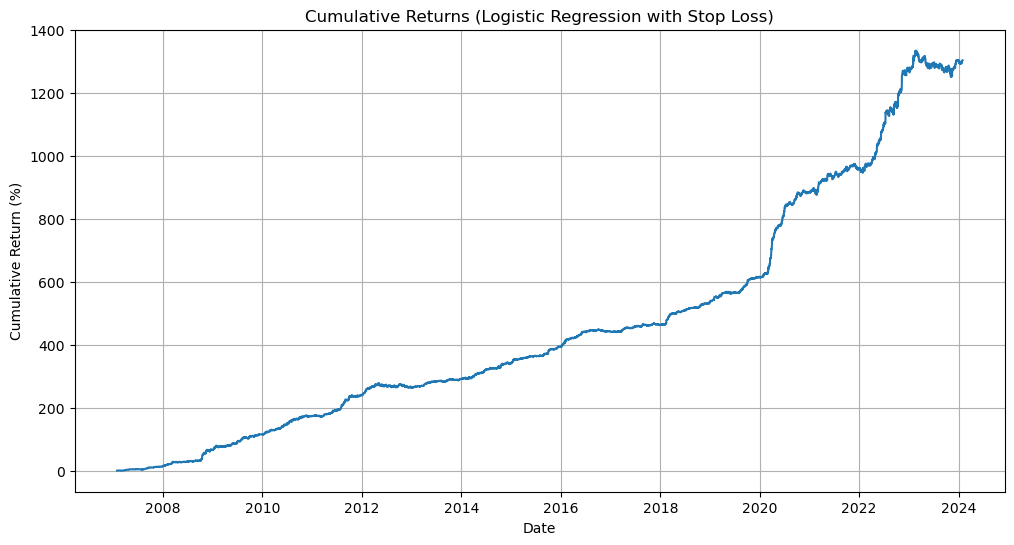

Final Cumulative Compounded Return: 1304.03%

Overall Test Accuracy : 53.55%
Overall Precision     : 36.94%
Overall Recall        : 37.35%
Overall F1 Score      : 36.89%
Overall ROC AUC       : 56.69%

Average Fold Test Return : 0.03776%

Standard Deviation of All Test Returns (Aggregated Daily): 0.25085%

Minimum Return (Aggregated Daily): -0.81088%

Optimal Horizon Counts:
(40 min)    8
(20 min)    6
(10 min)    3
Name: count, dtype: int64

Test Set Position Counts:
Neutral (0): 182
Long (1): 9435
Short (2): 7799


In [11]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score
)
import numpy as np
import pandas as pd
import os, random

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)

# feature_cols = all columns except 'DateTime' and the last 6 columns and also print out feature_cols and number of features
feature_cols = df_ml.columns[:-6].tolist()
feature_cols.remove('DateTime')
print("Feature Columns:", feature_cols)
print("Number of Features:", len(feature_cols))


# --- Configuration ---
horizons = [' (20 min)', ' (10 min)', ' (40 min)']

# --- Data Prep ---
df_ml = df_ml.dropna(subset=['Surprise']).sort_values('DateTime')
min_date = df_ml['DateTime'].min()
max_date = df_ml['DateTime'].max()

# --- Calculate Initial 30% Training Period ---
total_duration = max_date - min_date
initial_train_duration = total_duration * 0.3
train_end_date = min_date + initial_train_duration

# --- Tracking containers ---
all_test_returns = []
all_dates = []
all_test_preds = []
all_test_truths = []
all_test_probas = []
fold_mean_returns = []
best_horizons_list = []

def calculate_grouped_returns(df_group, horizon, stop_loss=None):
    """Calculate returns with position sizing and stop loss"""
    active_trades = df_group[df_group['pred'] != 0]
    if active_trades.empty:
        return 0.0

    # Create copies with reset index
    longs = active_trades[active_trades['pred'] == 1].copy().reset_index(drop=True)
    shorts = active_trades[active_trades['pred'] == 2].copy().reset_index(drop=True)

    total_confidence = longs['proba'].sum() + shorts['proba'].sum()
    if total_confidence == 0:
        return 0.0

    num_trades = len(longs) + len(shorts)

    long_returns = 0.0
    short_returns = 0.0

    # Process longs with capping
    if not longs.empty:
        long_weights = longs['proba'] / total_confidence
        for idx in longs.index:
            raw_return = longs.loc[idx, f'Forward Return{horizon}']
            capped_raw = max(stop_loss, raw_return) if stop_loss is not None else raw_return
            long_returns += capped_raw * long_weights.loc[idx]

    # Process shorts with capping
    if not shorts.empty:
        short_weights = shorts['proba'] / total_confidence
        for idx in shorts.index:
            raw_return = -shorts.loc[idx, f'Forward Return{horizon}']
            capped_raw = max(stop_loss, raw_return) if stop_loss is not None else raw_return
            short_returns += capped_raw * short_weights.loc[idx]

    net_return = (long_returns + short_returns)
    return net_return

# --- Main Loop ---
while True:
    val_start_date = train_end_date + pd.DateOffset(days=1)
    val_end_date = val_start_date + pd.DateOffset(years=1)
    test_start_date = val_end_date + pd.DateOffset(days=1)
    test_end_date = test_start_date + pd.DateOffset(years=1)

    if val_end_date > max_date or test_end_date > max_date:
        break

    train_mask = df_ml['DateTime'] <= train_end_date
    val_mask = (df_ml['DateTime'] >= val_start_date) & (df_ml['DateTime'] <= val_end_date)
    test_mask = (df_ml['DateTime'] >= test_start_date) & (df_ml['DateTime'] <= test_end_date)

    train_data = df_ml[train_mask]
    val_data = df_ml[val_mask]
    test_data = df_ml[test_mask]

    if val_data.empty or test_data.empty:
        print(f"Skipping period {val_start_date.date()} to {test_end_date.date()} (no data)")
        train_end_date += pd.DateOffset(years=1)
        continue

    # --- Horizon Optimization ---
    best_horizon, best_model, best_stop_loss = None, None, None
    best_val_return = -np.inf

    for horizon in horizons:
        # Feature scaling
        scaler = StandardScaler()
        X_train = scaler.fit_transform(train_data[feature_cols])
        X_val = scaler.transform(val_data[feature_cols])
        y_train = train_data[f'Target Signal{horizon}']
        y_val = val_data[f'Target Signal{horizon}']

        # Train Logistic Regression
        model = LogisticRegression(
            multi_class='multinomial',
            solver='saga',
            max_iter=100,
            random_state=42
        )
        model.fit(X_train, y_train)

        # Training stop loss calculation
        train_preds = model.predict(X_train)
        train_probas = model.predict_proba(X_train)
        class_map = {cls: idx for idx, cls in enumerate(model.classes_)}

        train_trade_df = pd.DataFrame({
            'DateTime': train_data['DateTime'],
            'pred': train_preds,
            'proba': [proba[class_map[pred]] for pred, proba in zip(train_preds, train_probas)],
            f'Forward Return{horizon}': train_data[f'Forward Return{horizon}']
        })

        train_raw_returns = []
        for _, row in train_trade_df.iterrows():
            if row['pred'] == 1:
                train_raw_returns.append(row[f'Forward Return{horizon}'])
            elif row['pred'] == 2:
                train_raw_returns.append(-row[f'Forward Return{horizon}'])
        stop_loss_train = np.percentile(train_raw_returns, 5) if train_raw_returns else None

        # Validation predictions and stop loss
        val_preds = model.predict(X_val)
        val_probas = model.predict_proba(X_val)
        val_trade_df = pd.DataFrame({
            'DateTime': val_data['DateTime'],
            'pred': val_preds,
            'proba': [proba[class_map[pred]] for pred, proba in zip(val_preds, val_probas)],
            f'Forward Return{horizon}': val_data[f'Forward Return{horizon}']
        })

        val_raw_returns = []
        for _, row in val_trade_df.iterrows():
            if row['pred'] == 1:
                val_raw_returns.append(row[f'Forward Return{horizon}'])
            elif row['pred'] == 2:
                val_raw_returns.append(-row[f'Forward Return{horizon}'])
        stop_loss_val = np.percentile(val_raw_returns, 5) if val_raw_returns else None

        # Validate using training stop loss
        val_returns = val_trade_df.groupby('DateTime').apply(
            lambda x: calculate_grouped_returns(x, horizon, stop_loss_train)
        ).values

        total_val_return = (1 + val_returns).prod() - 1

        if total_val_return > best_val_return:
            best_val_return = total_val_return
            best_horizon = horizon
            best_model = model
            best_stop_loss = stop_loss_val

    # --- Test Best Model ---
    if best_model and best_stop_loss is not None:
        X_test = scaler.transform(test_data[feature_cols])
        test_preds = best_model.predict(X_test)
        test_probas = best_model.predict_proba(X_test)
        y_test = test_data[f'Target Signal{best_horizon}'].values

        class_map = {cls: idx for idx, cls in enumerate(best_model.classes_)}
        test_trade_df = pd.DataFrame({
            'DateTime': test_data['DateTime'],
            'pred': test_preds,
            'proba': [proba[class_map[pred]] for pred, proba in zip(test_preds, test_probas)],
            f'Forward Return{best_horizon}': test_data[f'Forward Return{best_horizon}']
        })

        grouped_returns = test_trade_df.groupby('DateTime').apply(
            lambda x: calculate_grouped_returns(x, best_horizon, best_stop_loss)
        ).values

        all_test_returns.extend(grouped_returns)
        all_dates.extend(test_trade_df['DateTime'].unique().tolist())
        all_test_preds.extend(test_preds)
        all_test_truths.extend(y_test)
        all_test_probas.append(test_probas)
        fold_mean_returns.append(np.mean(grouped_returns))
        best_horizons_list.append(best_horizon or 'standard')

    train_end_date += pd.DateOffset(years=1)

# --- Results ---
if all_test_returns:
    cumulative_returns = (1 + np.array(all_test_returns)).cumprod() - 1
    std_dev_individual = np.std(all_test_returns) * 100
    min_return = np.nanmin(all_test_returns) * 100 if all_test_returns else 0.0

    plt.figure(figsize=(12, 6))
    plt.plot(all_dates, cumulative_returns * 100)
    plt.title('Cumulative Returns (Logistic Regression with Stop Loss)')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return (%)')
    plt.grid(True)
    plt.show()

    print(f"Final Cumulative Compounded Return: {cumulative_returns[-1]*100:.2f}%")
    print(f"\nOverall Test Accuracy : {accuracy_score(all_test_truths, all_test_preds)*100:.2f}%")
    print(f"Overall Precision     : {precision_score(all_test_truths, all_test_preds, average='macro', zero_division=0)*100:.2f}%")
    print(f"Overall Recall        : {recall_score(all_test_truths, all_test_preds, average='macro', zero_division=0)*100:.2f}%")
    print(f"Overall F1 Score      : {f1_score(all_test_truths, all_test_preds, average='macro', zero_division=0)*100:.2f}%")
    print(f"Overall ROC AUC       : {roc_auc_score(all_test_truths, np.vstack(all_test_probas), multi_class='ovo', average='macro')*100:.2f}%")
    print(f"\nAverage Fold Test Return : {np.mean(fold_mean_returns)*100:.5f}%")
    print(f"\nStandard Deviation of All Test Returns (Aggregated Daily): {std_dev_individual:.5f}%")
    print(f"\nMinimum Return (Aggregated Daily): {min_return:.5f}%")
    print("\nOptimal Horizon Counts:")
    print(pd.Series(best_horizons_list).value_counts())
    print("\nTest Set Position Counts:")
    counts = pd.Series(all_test_preds).value_counts().sort_index()
    print(f"Neutral (0): {counts.get(0, 0)}")
    print(f"Long (1): {counts.get(1, 0)}")
    print(f"Short (2): {counts.get(2, 0)}")

else:
    print("No valid test periods found")

In [12]:
# LR confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

# Add this after your existing print statements
print("\nConfusion Matrix:")
cm = confusion_matrix(all_test_truths, all_test_preds)
cm_df = pd.DataFrame(cm,
                    index=['Actual Neutral (0)', 'Actual Long (1)', 'Actual Short (2)'],
                    columns=['Pred Neutral (0)', 'Pred Long (1)', 'Pred Short (2)'])
print(cm_df)

print("\nClassification Report:")
print(classification_report(all_test_truths, all_test_preds,
                           target_names=['Neutral (0)', 'Long (1)', 'Short (2)']))


Confusion Matrix:
                    Pred Neutral (0)  Pred Long (1)  Pred Short (2)
Actual Neutral (0)                 5            392             307
Actual Long (1)                  109           5149            3319
Actual Short (2)                  68           3894            4173

Classification Report:
              precision    recall  f1-score   support

 Neutral (0)       0.03      0.01      0.01       704
    Long (1)       0.55      0.60      0.57      8577
   Short (2)       0.54      0.51      0.52      8135

    accuracy                           0.54     17416
   macro avg       0.37      0.37      0.37     17416
weighted avg       0.52      0.54      0.53     17416



In [13]:
sorted_dates = sorted(all_dates)
print(f"First test set date: {sorted_dates[0].date()}")
print(f"Last test set date: {sorted_dates[-1].date()}")

# So can see overall that our models have roughly 17 years worth of test observations  except the statistical model which doesn't trade in the past 2 years
# This is important for the annual compounded return calculation in our tables

First test set date: 2007-01-30
Last test set date: 2024-01-29
